In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from utils.utils import set_seed
set_seed()


from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
#torch.use_deterministic_algorithms(False)
#torch.backends.cudnn.benchmark = False
#torch.autograd.profiler.profile(enabled=False)
#torch.autograd.profiler.emit_nvtx(enabled=False)
#torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = '167772160'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [4]:
df=df.to_pandas()

In [5]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [6]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [7]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

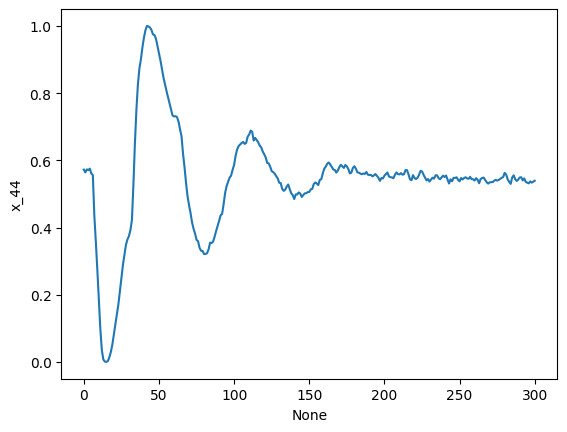

In [8]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [9]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_18','x_19','x_44','x_50']]

In [10]:
normal = df[200:]
bad = df[0:200]

In [11]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50'], dtype='object')

In [12]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [13]:
cols = df.columns.tolist()

In [14]:
cols

['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50']

# Pretraining

In [15]:
TIME_STEPS = 3
BATCH_SIZE = 100
hidden_dim = 256
latent_dim = 16
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=prior_adj).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

# Train on nominal data
# print("Pretraining on nominal data...")
fine_tuned.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=5.0,alpha_max=2.5)

X_data = torch.empty(0,device=device)
T_data = torch.empty(0,device=device)
for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
    X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
    T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))


causes= fine_tuned.infer_causal_effect(X_data=X_data,T_data=T_data,target_variable='x_4',
                                       labels=cols,non_causal_indices=[],root_rank=False)
causes

Epoch 1: Loss = 947.5201
Recon Loss =823.8625, KL Loss = 0.0019, Sparsity Loss = 33.2894, Lagrangian Loss = 90.3664
Epoch 51: Loss = 149.2762
Recon Loss =5.0998, KL Loss = 1.4245, Sparsity Loss = 32.2786, Lagrangian Loss = 110.4733
Early stopping triggered. Last Epoch: 80
Recon Loss =3.2578, KL Loss = 1.7347, Sparsity Loss = 32.9214, Lagrangian Loss = 126.9844
Epoch 1: Loss = 1677.4421
Recon Loss =866.1261, KL Loss = 0.0014, Sparsity Loss = 49.6196, Lagrangian Loss = 761.6951
Early stopping triggered. Last Epoch: 46
Recon Loss =857.6923, KL Loss = 0.0014, Sparsity Loss = 47.5767, Lagrangian Loss = 551.7401


,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_19,0.960609,0.902041,1.000000,0.889287,0.937984,0.666667
x_16,0.925573,0.999414,0.827296,0.947045,0.924832,0.500000
x_50,1.000000,0.990153,0.996422,0.613642,0.900054,0.833334
x_7,0.894371,0.884957,0.878456,0.895911,0.888424,1.000000
x_44,0.820930,0.849456,0.766384,1.000000,0.859192,0.833334
x_18,0.776031,0.796995,0.731378,0.963031,0.816859,0.333333
x_1,0.805169,0.786140,0.799359,0.442268,0.708234,0.000000
x_13,0.909537,1.000000,0.793314,0.000000,0.675713,0.833334
x_4,0.000000,0.000000,0.000000,NaN,0.000000,1.000000


In [16]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_16',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_13,0.922178,0.800994,0.937829,1.000000,0.915250,1.000000
x_19,0.968235,0.984078,0.865286,0.684670,0.875567,0.833334
x_7,0.987402,0.876167,0.989264,0.615925,0.867189,1.000000
x_44,0.988794,0.866267,1.000000,0.384180,0.809810,1.000000
x_18,0.946415,0.973951,0.835506,0.450784,0.801664,0.333333
x_50,1.000000,0.999280,0.908882,0.054009,0.740543,1.000000
x_1,0.999688,0.996848,0.910354,0.000000,0.726723,0.000000
x_4,0.900547,1.000000,0.734382,0.027700,0.665657,0.500000
x_16,0.000000,0.000000,0.000000,NaN,0.000000,0.500000


In [17]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_18',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_1,0.992771,1.000000,0.921627,0.689536,0.900984,0.000000
x_7,0.865555,0.692126,1.000000,1.000000,0.889420,0.500001
x_4,1.000000,0.995929,0.941884,0.452708,0.847630,0.750001
x_16,0.916187,0.912990,0.856662,0.363196,0.762259,0.500001
x_50,0.976023,0.947503,0.944378,0.164862,0.758192,0.500001
x_44,0.885197,0.817055,0.900137,0.157568,0.689989,0.750001
x_13,0.839475,0.737848,0.895835,0.114664,0.646956,1.000000
x_19,0.865351,0.841567,0.832049,0.000000,0.634742,0.250000
x_18,0.000000,0.000000,0.000000,NaN,0.000000,0.250000


In [18]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_13',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_50,0.984821,1.000000,0.852948,1.000000,0.959442,0.833334
x_4,1.000000,0.989450,0.895815,0.814304,0.924892,0.666667
x_7,0.933002,0.823346,0.938078,0.950219,0.911161,1.000000
x_16,0.942042,0.782816,1.000000,0.601608,0.831616,0.000000
x_18,0.960939,0.907956,0.903281,0.319114,0.772822,0.166667
x_44,0.953030,0.898331,0.897587,0.194953,0.735975,1.000000
x_19,0.928140,0.840407,0.909923,0.128363,0.701708,0.666667
x_1,0.784241,0.629873,0.857314,0.000000,0.567857,0.666667
x_13,0.000000,0.000000,0.000000,NaN,0.000000,1.000000


In [19]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_7',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_13,1.000000,0.957192,0.990487,0.776878,0.931139,0.666668
x_16,0.846439,0.643726,1.000000,1.000000,0.872541,0.333334
x_1,0.915724,0.777906,0.999841,0.677782,0.842813,0.333334
x_19,0.805076,0.710023,0.850024,0.975539,0.835165,0.333334
x_44,0.976898,1.000000,0.896529,0.461646,0.833768,0.333334
x_4,0.919341,0.897303,0.883177,0.346652,0.761618,0.333334
x_18,0.869200,0.777636,0.906086,0.182256,0.683795,0.000000
x_50,0.893107,0.888082,0.839359,0.000000,0.655137,0.333334
x_7,0.000000,0.000000,0.000000,NaN,0.000000,1.000000


In [20]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_50',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_44,0.889809,0.878924,0.857807,0.965354,0.897974,0.857143
x_19,0.964974,0.983607,0.902798,0.722628,0.893502,0.714286
x_18,0.845775,0.805150,0.847787,1.000000,0.874678,0.000000
x_7,0.964263,0.959413,0.927664,0.619863,0.867801,1.000000
x_4,0.923611,0.868782,0.939680,0.617789,0.837465,0.571429
x_13,1.000000,1.000000,0.961570,0.381261,0.835708,0.714286
x_16,0.908889,0.785123,1.000000,0.000000,0.673503,0.428571
x_1,0.786929,0.640955,0.908467,0.077750,0.603525,0.142857
x_50,0.000000,0.000000,0.000000,NaN,0.000000,0.714286


In [21]:
causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_19',cols,non_causal_indices=[])
causes

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_18,0.928873,0.978526,0.864197,0.761702,0.883325,0.000000
x_16,0.843321,0.873558,0.796724,1.000000,0.878401,0.400000
x_4,0.877488,0.790500,0.960353,0.621424,0.812441,0.400000
x_44,0.918117,0.884326,0.944458,0.496819,0.810930,1.000000
x_13,0.915939,0.927384,0.892303,0.476662,0.803072,1.000000
x_50,1.000000,1.000000,1.000000,0.196864,0.799216,0.400000
x_1,0.768506,0.742738,0.786407,0.860081,0.789433,0.199999
x_7,0.968724,0.994042,0.935506,0.000000,0.724568,1.000000
x_19,0.000000,0.000000,0.000000,NaN,0.000000,1.000000


In [25]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [32]:
TIME_STEPS = 3
BATCH_SIZE = 25
hidden_dim = 256
latent_dim = 8
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-0)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=0.2,alpha_max=0.2)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
pd.DataFrame((prior_adj).cpu().detach().numpy(),index=cols,columns=cols)

Epoch 1: Loss = 180.8236
Recon Loss =56.0810, KL Loss = 0.0677, Sparsity Loss = 33.4604, Lagrangian Loss = 25.7073
Early stopping triggered. Last Epoch: 48
Recon Loss =0.5477, KL Loss = 0.0002, Sparsity Loss = 33.9743, Lagrangian Loss = 24.5831


,x_1,x_4,x_7,x_13,x_16,x_18,x_19,x_44,x_50
x_1,0.268941,0.644539,0.522534,0.551943,0.612221,0.604866,0.541450,0.590475,0.609725
x_4,0.615948,0.268941,0.520956,0.554811,0.646218,0.626983,0.513627,0.628174,0.648861
x_7,0.542042,0.571395,0.268941,0.602807,0.556427,0.554175,0.643402,0.533793,0.544084
x_13,0.540882,0.559267,0.643989,0.268941,0.538686,0.576236,0.605953,0.552551,0.532405
x_16,0.644338,0.604529,0.553317,0.530696,0.268941,0.630805,0.555686,0.615146,0.606393
x_18,0.642389,0.626783,0.550396,0.536084,0.641907,0.268941,0.558934,0.611544,0.594505
x_19,0.559507,0.556449,0.623338,0.638873,0.562238,0.553338,0.268941,0.524894,0.541042
x_44,0.620576,0.654581,0.553515,0.529389,0.599364,0.627805,0.553022,0.268941,0.641834
x_50,0.608802,0.633360,0.554605,0.532644,0.645442,0.660048,0.513911,0.609381,0.268941


In [33]:

edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-0)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_nominal, optimizer, num_epochs=250, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=0.2,alpha_max=0.2)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_1','x_44']) | (edge_cause_2 in ['x_1','x_44']) | (edge_cause_3 in ['x_1','x_44']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_1','x_44']) | (total_score_cause_2 in ['x_1','x_44']) | ( total_score_cause_3 in ['x_1','x_44']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_1','x_44']) | (counterfactual_cause_2 in ['x_1','x_44']) | (counterfactual_cause_3 in ['x_1','x_44']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_1','x_44']) | (instant_cause_2 in ['x_1','x_44']) |( instant_cause_3 in ['x_1','x_44'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_1','x_44']) | (lag_cause_2 in ['x_1','x_44'])  | (lag_cause_3 in ['x_1','x_44']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_1','x_44']) | (rr_cause_2 in ['x_1','x_44']) | (rr_cause_3 in ['x_1','x_44']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 339.2449
Recon Loss =206.3795, KL Loss = 0.0024, Sparsity Loss = 46.2560, Lagrangian Loss = 67.8252
Early stopping triggered. Last Epoch: 34
Recon Loss =206.5783, KL Loss = 0.0024, Sparsity Loss = 46.8429, Lagrangian Loss = 81.8489


2025-03-18 20:56:29,638 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 100.00  


Epoch 1: Loss = 331.8032
Recon Loss =193.1337, KL Loss = 0.0007, Sparsity Loss = 48.5448, Lagrangian Loss = 98.0229
Early stopping triggered. Last Epoch: 39
Recon Loss =192.3735, KL Loss = 0.0007, Sparsity Loss = 46.7816, Lagrangian Loss = 78.5215


2025-03-18 20:56:36,810 INFO -- Edge Accuracy = 50.00, Instantaneous Accuracy = 50.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 329.4909
Recon Loss =187.3076, KL Loss = 0.0022, Sparsity Loss = 46.2384, Lagrangian Loss = 69.8043
Epoch 51: Loss = 323.0338
Recon Loss =190.3420, KL Loss = 0.0022, Sparsity Loss = 47.0186, Lagrangian Loss = 76.6265
Epoch 101: Loss = 334.6929
Recon Loss =186.3015, KL Loss = 0.0022, Sparsity Loss = 47.3794, Lagrangian Loss = 84.5864
Early stopping triggered. Last Epoch: 101
Recon Loss =188.4141, KL Loss = 0.0022, Sparsity Loss = 45.8411, Lagrangian Loss = 65.5837


2025-03-18 20:56:54,267 INFO -- Edge Accuracy = 66.67, Instantaneous Accuracy = 66.67, Lagged Accuracy = 66.67, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 66.67  


Epoch 1: Loss = 341.9557
Recon Loss =213.0356, KL Loss = 0.0036, Sparsity Loss = 46.3557, Lagrangian Loss = 81.5440
Early stopping triggered. Last Epoch: 31
Recon Loss =211.5249, KL Loss = 0.0036, Sparsity Loss = 46.1983, Lagrangian Loss = 74.2587


2025-03-18 20:57:00,050 INFO -- Edge Accuracy = 75.00, Instantaneous Accuracy = 75.00, Lagged Accuracy = 75.00, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 333.9895
Recon Loss =183.0444, KL Loss = 0.0020, Sparsity Loss = 48.3161, Lagrangian Loss = 98.8868
Early stopping triggered. Last Epoch: 31
Recon Loss =182.9424, KL Loss = 0.0020, Sparsity Loss = 48.2616, Lagrangian Loss = 96.5632


2025-03-18 20:57:05,933 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 80.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 60.00  


Epoch 1: Loss = 322.8201
Recon Loss =182.4622, KL Loss = 0.0024, Sparsity Loss = 46.0555, Lagrangian Loss = 72.4906
Epoch 51: Loss = 312.6423
Recon Loss =176.3662, KL Loss = 0.0024, Sparsity Loss = 46.2517, Lagrangian Loss = 88.5255
Early stopping triggered. Last Epoch: 80
Recon Loss =178.2677, KL Loss = 0.0024, Sparsity Loss = 46.7285, Lagrangian Loss = 84.2737


2025-03-18 20:57:19,837 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 83.33, Lagged Accuracy = 83.33, Counterfactual Accuracy = 100.00,  Blended Accuracy = 100.00,  RR Accuracy = 66.67  


Epoch 1: Loss = 338.7035
Recon Loss =199.7307, KL Loss = 0.0025, Sparsity Loss = 48.0182, Lagrangian Loss = 93.4773
Early stopping triggered. Last Epoch: 49
Recon Loss =197.4453, KL Loss = 0.0025, Sparsity Loss = 47.1597, Lagrangian Loss = 76.2664


2025-03-18 20:57:28,584 INFO -- Edge Accuracy = 85.71, Instantaneous Accuracy = 85.71, Lagged Accuracy = 85.71, Counterfactual Accuracy = 85.71,  Blended Accuracy = 85.71,  RR Accuracy = 71.43  


Epoch 1: Loss = 339.8398
Recon Loss =202.0997, KL Loss = 0.0033, Sparsity Loss = 46.9076, Lagrangian Loss = 74.1991
Early stopping triggered. Last Epoch: 41
Recon Loss =205.9369, KL Loss = 0.0033, Sparsity Loss = 45.2240, Lagrangian Loss = 59.7769


2025-03-18 20:57:36,088 INFO -- Edge Accuracy = 87.50, Instantaneous Accuracy = 87.50, Lagged Accuracy = 87.50, Counterfactual Accuracy = 75.00,  Blended Accuracy = 75.00,  RR Accuracy = 75.00  


Epoch 1: Loss = 331.9559
Recon Loss =200.9631, KL Loss = 0.0014, Sparsity Loss = 46.8183, Lagrangian Loss = 74.9346
Epoch 51: Loss = 337.6224
Recon Loss =203.1844, KL Loss = 0.0014, Sparsity Loss = 45.9618, Lagrangian Loss = 69.5121
Early stopping triggered. Last Epoch: 79
Recon Loss =202.7448, KL Loss = 0.0014, Sparsity Loss = 45.8836, Lagrangian Loss = 64.4074


2025-03-18 20:57:49,895 INFO -- Edge Accuracy = 77.78, Instantaneous Accuracy = 88.89, Lagged Accuracy = 77.78, Counterfactual Accuracy = 66.67,  Blended Accuracy = 66.67,  RR Accuracy = 66.67  


Epoch 1: Loss = 357.6803
Recon Loss =212.5864, KL Loss = 0.0039, Sparsity Loss = 47.9592, Lagrangian Loss = 96.2373
Epoch 51: Loss = 350.3479
Recon Loss =214.5603, KL Loss = 0.0039, Sparsity Loss = 47.8730, Lagrangian Loss = 91.2795
Early stopping triggered. Last Epoch: 64
Recon Loss =211.5472, KL Loss = 0.0039, Sparsity Loss = 46.5825, Lagrangian Loss = 72.2463


2025-03-18 20:58:01,294 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 90.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 60.00,  RR Accuracy = 70.00  


Epoch 1: Loss = 344.5853
Recon Loss =198.8622, KL Loss = 0.0028, Sparsity Loss = 47.4406, Lagrangian Loss = 80.7018
Early stopping triggered. Last Epoch: 42
Recon Loss =197.0366, KL Loss = 0.0028, Sparsity Loss = 47.0382, Lagrangian Loss = 79.7109


2025-03-18 20:58:09,037 INFO -- Edge Accuracy = 81.82, Instantaneous Accuracy = 90.91, Lagged Accuracy = 81.82, Counterfactual Accuracy = 54.55,  Blended Accuracy = 63.64,  RR Accuracy = 72.73  


Epoch 1: Loss = 325.8356
Recon Loss =190.7728, KL Loss = 0.0014, Sparsity Loss = 46.6635, Lagrangian Loss = 74.7603
Epoch 51: Loss = 321.2916
Recon Loss =190.9207, KL Loss = 0.0014, Sparsity Loss = 47.5090, Lagrangian Loss = 87.7052
Early stopping triggered. Last Epoch: 84
Recon Loss =193.9751, KL Loss = 0.0014, Sparsity Loss = 48.3358, Lagrangian Loss = 101.7380


2025-03-18 20:58:23,858 INFO -- Edge Accuracy = 75.00, Instantaneous Accuracy = 83.33, Lagged Accuracy = 75.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 58.33,  RR Accuracy = 75.00  


Epoch 1: Loss = 339.4050
Recon Loss =198.9221, KL Loss = 0.0020, Sparsity Loss = 46.1507, Lagrangian Loss = 77.2975
Early stopping triggered. Last Epoch: 40
Recon Loss =199.7109, KL Loss = 0.0020, Sparsity Loss = 48.1800, Lagrangian Loss = 101.5249


2025-03-18 20:58:31,259 INFO -- Edge Accuracy = 76.92, Instantaneous Accuracy = 84.62, Lagged Accuracy = 76.92, Counterfactual Accuracy = 53.85,  Blended Accuracy = 61.54,  RR Accuracy = 69.23  


Epoch 1: Loss = 345.3475
Recon Loss =197.4405, KL Loss = 0.0014, Sparsity Loss = 47.0651, Lagrangian Loss = 78.4008
Early stopping triggered. Last Epoch: 43
Recon Loss =197.3994, KL Loss = 0.0014, Sparsity Loss = 47.1144, Lagrangian Loss = 93.0221


2025-03-18 20:58:39,138 INFO -- Edge Accuracy = 78.57, Instantaneous Accuracy = 85.71, Lagged Accuracy = 78.57, Counterfactual Accuracy = 57.14,  Blended Accuracy = 64.29,  RR Accuracy = 71.43  


Epoch 1: Loss = 334.3962
Recon Loss =199.4213, KL Loss = 0.0020, Sparsity Loss = 45.5038, Lagrangian Loss = 64.5515
Epoch 51: Loss = 338.6804
Recon Loss =200.6808, KL Loss = 0.0020, Sparsity Loss = 47.2476, Lagrangian Loss = 78.4043
Early stopping triggered. Last Epoch: 68
Recon Loss =202.1396, KL Loss = 0.0020, Sparsity Loss = 46.4413, Lagrangian Loss = 71.5252


2025-03-18 20:58:51,268 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 86.67, Lagged Accuracy = 80.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 66.67,  RR Accuracy = 73.33  


Epoch 1: Loss = 331.6091
Recon Loss =205.2221, KL Loss = 0.0026, Sparsity Loss = 46.6201, Lagrangian Loss = 78.2058
Early stopping triggered. Last Epoch: 42
Recon Loss =202.2160, KL Loss = 0.0026, Sparsity Loss = 47.3556, Lagrangian Loss = 85.4149


2025-03-18 20:58:59,024 INFO -- Edge Accuracy = 81.25, Instantaneous Accuracy = 87.50, Lagged Accuracy = 81.25, Counterfactual Accuracy = 62.50,  Blended Accuracy = 68.75,  RR Accuracy = 75.00  


Epoch 1: Loss = 345.7864
Recon Loss =191.9345, KL Loss = 0.0021, Sparsity Loss = 46.7260, Lagrangian Loss = 75.0477
Epoch 51: Loss = 340.2709
Recon Loss =191.6979, KL Loss = 0.0021, Sparsity Loss = 47.0162, Lagrangian Loss = 83.2443
Early stopping triggered. Last Epoch: 59
Recon Loss =192.1119, KL Loss = 0.0021, Sparsity Loss = 46.6511, Lagrangian Loss = 90.6009


2025-03-18 20:59:09,603 INFO -- Edge Accuracy = 82.35, Instantaneous Accuracy = 88.24, Lagged Accuracy = 76.47, Counterfactual Accuracy = 64.71,  Blended Accuracy = 70.59,  RR Accuracy = 70.59  


Epoch 1: Loss = 335.1851
Recon Loss =200.2745, KL Loss = 0.0017, Sparsity Loss = 46.8663, Lagrangian Loss = 72.5133
Epoch 51: Loss = 329.5665
Recon Loss =200.3478, KL Loss = 0.0017, Sparsity Loss = 45.7221, Lagrangian Loss = 62.2768
Early stopping triggered. Last Epoch: 57
Recon Loss =201.5123, KL Loss = 0.0017, Sparsity Loss = 46.8854, Lagrangian Loss = 78.2863


2025-03-18 20:59:19,871 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 88.89, Lagged Accuracy = 77.78, Counterfactual Accuracy = 61.11,  Blended Accuracy = 66.67,  RR Accuracy = 72.22  


Epoch 1: Loss = 362.6976
Recon Loss =199.7973, KL Loss = 0.0021, Sparsity Loss = 48.2230, Lagrangian Loss = 115.6355
Epoch 51: Loss = 357.9128
Recon Loss =202.2667, KL Loss = 0.0021, Sparsity Loss = 48.5629, Lagrangian Loss = 114.9612
Epoch 101: Loss = 374.6592
Recon Loss =204.2350, KL Loss = 0.0021, Sparsity Loss = 46.5437, Lagrangian Loss = 87.7203
Early stopping triggered. Last Epoch: 120
Recon Loss =198.5423, KL Loss = 0.0021, Sparsity Loss = 48.7393, Lagrangian Loss = 128.1038


2025-03-18 20:59:40,781 INFO -- Edge Accuracy = 78.95, Instantaneous Accuracy = 84.21, Lagged Accuracy = 78.95, Counterfactual Accuracy = 57.89,  Blended Accuracy = 63.16,  RR Accuracy = 73.68  


Epoch 1: Loss = 353.7647
Recon Loss =192.1852, KL Loss = 0.0023, Sparsity Loss = 48.9313, Lagrangian Loss = 114.2834
Epoch 51: Loss = 346.0465
Recon Loss =191.3927, KL Loss = 0.0023, Sparsity Loss = 47.0727, Lagrangian Loss = 86.9000
Early stopping triggered. Last Epoch: 76
Recon Loss =192.6792, KL Loss = 0.0023, Sparsity Loss = 47.7369, Lagrangian Loss = 91.7204


2025-03-18 20:59:54,276 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 85.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 55.00,  Blended Accuracy = 60.00,  RR Accuracy = 70.00  


Epoch 1: Loss = 345.9719
Recon Loss =196.2282, KL Loss = 0.0011, Sparsity Loss = 45.8904, Lagrangian Loss = 65.5383
Early stopping triggered. Last Epoch: 31
Recon Loss =198.7813, KL Loss = 0.0011, Sparsity Loss = 44.5617, Lagrangian Loss = 63.8046


2025-03-18 21:00:00,178 INFO -- Edge Accuracy = 80.95, Instantaneous Accuracy = 85.71, Lagged Accuracy = 80.95, Counterfactual Accuracy = 57.14,  Blended Accuracy = 61.90,  RR Accuracy = 66.67  


Epoch 1: Loss = 336.7107
Recon Loss =190.5860, KL Loss = 0.0025, Sparsity Loss = 48.1978, Lagrangian Loss = 94.4760
Early stopping triggered. Last Epoch: 34
Recon Loss =193.3929, KL Loss = 0.0025, Sparsity Loss = 46.5136, Lagrangian Loss = 84.1984


2025-03-18 21:00:06,537 INFO -- Edge Accuracy = 81.82, Instantaneous Accuracy = 86.36, Lagged Accuracy = 77.27, Counterfactual Accuracy = 54.55,  Blended Accuracy = 63.64,  RR Accuracy = 68.18  


Epoch 1: Loss = 358.4248
Recon Loss =200.7206, KL Loss = 0.0016, Sparsity Loss = 46.0578, Lagrangian Loss = 70.9155
Early stopping triggered. Last Epoch: 36
Recon Loss =202.4429, KL Loss = 0.0016, Sparsity Loss = 48.1423, Lagrangian Loss = 95.0748


2025-03-18 21:00:13,156 INFO -- Edge Accuracy = 82.61, Instantaneous Accuracy = 86.96, Lagged Accuracy = 73.91, Counterfactual Accuracy = 52.17,  Blended Accuracy = 65.22,  RR Accuracy = 65.22  


Epoch 1: Loss = 346.0463
Recon Loss =215.1415, KL Loss = 0.0020, Sparsity Loss = 47.1090, Lagrangian Loss = 78.7173
Epoch 51: Loss = 349.3813
Recon Loss =211.0893, KL Loss = 0.0020, Sparsity Loss = 46.0504, Lagrangian Loss = 74.0593
Early stopping triggered. Last Epoch: 68
Recon Loss =214.4621, KL Loss = 0.0020, Sparsity Loss = 48.2837, Lagrangian Loss = 103.5202


2025-03-18 21:00:25,131 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 87.50, Lagged Accuracy = 75.00, Counterfactual Accuracy = 54.17,  Blended Accuracy = 66.67,  RR Accuracy = 66.67  


Epoch 1: Loss = 375.8833
Recon Loss =211.1843, KL Loss = 0.0025, Sparsity Loss = 49.0931, Lagrangian Loss = 114.0239
Epoch 51: Loss = 390.6217
Recon Loss =217.1740, KL Loss = 0.0025, Sparsity Loss = 49.3151, Lagrangian Loss = 128.4837
Early stopping triggered. Last Epoch: 70
Recon Loss =212.5508, KL Loss = 0.0025, Sparsity Loss = 49.2752, Lagrangian Loss = 123.5854


2025-03-18 21:00:37,394 INFO -- Edge Accuracy = 84.00, Instantaneous Accuracy = 88.00, Lagged Accuracy = 72.00, Counterfactual Accuracy = 52.00,  Blended Accuracy = 64.00,  RR Accuracy = 64.00  


Epoch 1: Loss = 350.2736
Recon Loss =215.8726, KL Loss = 0.0027, Sparsity Loss = 46.8003, Lagrangian Loss = 86.5812
Epoch 51: Loss = 357.6506
Recon Loss =213.8204, KL Loss = 0.0027, Sparsity Loss = 48.6931, Lagrangian Loss = 115.3527
Early stopping triggered. Last Epoch: 77
Recon Loss =212.2899, KL Loss = 0.0027, Sparsity Loss = 47.5467, Lagrangian Loss = 87.3895


2025-03-18 21:00:50,921 INFO -- Edge Accuracy = 84.62, Instantaneous Accuracy = 88.46, Lagged Accuracy = 73.08, Counterfactual Accuracy = 50.00,  Blended Accuracy = 61.54,  RR Accuracy = 61.54  


Epoch 1: Loss = 349.7842
Recon Loss =195.0355, KL Loss = 0.0020, Sparsity Loss = 47.9059, Lagrangian Loss = 87.3636
Early stopping triggered. Last Epoch: 44
Recon Loss =197.5073, KL Loss = 0.0020, Sparsity Loss = 48.1197, Lagrangian Loss = 111.8341


2025-03-18 21:00:58,803 INFO -- Edge Accuracy = 85.19, Instantaneous Accuracy = 85.19, Lagged Accuracy = 74.07, Counterfactual Accuracy = 51.85,  Blended Accuracy = 62.96,  RR Accuracy = 59.26  


Epoch 1: Loss = 336.2931
Recon Loss =201.6404, KL Loss = 0.0021, Sparsity Loss = 45.8079, Lagrangian Loss = 60.7245
Epoch 51: Loss = 343.5644
Recon Loss =202.1386, KL Loss = 0.0021, Sparsity Loss = 47.0301, Lagrangian Loss = 79.8680
Early stopping triggered. Last Epoch: 53
Recon Loss =200.8325, KL Loss = 0.0021, Sparsity Loss = 46.5228, Lagrangian Loss = 72.2420


2025-03-18 21:01:08,320 INFO -- Edge Accuracy = 85.71, Instantaneous Accuracy = 85.71, Lagged Accuracy = 75.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 64.29,  RR Accuracy = 60.71  


Epoch 1: Loss = 353.6987
Recon Loss =216.8077, KL Loss = 0.0022, Sparsity Loss = 46.3147, Lagrangian Loss = 70.2120
Epoch 51: Loss = 345.1086
Recon Loss =212.3732, KL Loss = 0.0022, Sparsity Loss = 44.9465, Lagrangian Loss = 58.8086
Early stopping triggered. Last Epoch: 57
Recon Loss =210.7558, KL Loss = 0.0022, Sparsity Loss = 46.5044, Lagrangian Loss = 78.9982


2025-03-18 21:01:18,399 INFO -- Edge Accuracy = 86.21, Instantaneous Accuracy = 86.21, Lagged Accuracy = 72.41, Counterfactual Accuracy = 48.28,  Blended Accuracy = 65.52,  RR Accuracy = 62.07  


Epoch 1: Loss = 329.7691
Recon Loss =195.7222, KL Loss = 0.0037, Sparsity Loss = 46.8423, Lagrangian Loss = 76.0226
Early stopping triggered. Last Epoch: 32
Recon Loss =193.9079, KL Loss = 0.0037, Sparsity Loss = 47.7669, Lagrangian Loss = 84.8680


2025-03-18 21:01:24,422 INFO -- Edge Accuracy = 86.67, Instantaneous Accuracy = 86.67, Lagged Accuracy = 73.33, Counterfactual Accuracy = 46.67,  Blended Accuracy = 66.67,  RR Accuracy = 63.33  


In [47]:
causes.sort_values(by='lagged',ascending=False)[0:3]

,causes,instantaneous,lagged,counterfactuals,causal_strength,RootRank
x_18,1.000000,0.927344,1.000000,0.577954,0.876324,1.000000
x_19,0.885413,0.721384,0.976285,0.303059,0.721535,0.000000
x_7,0.843736,0.746555,0.880709,0.000000,0.617750,0.666668


In [44]:

import torch
import torchviz
from CARAT.model import CausalGraphVAE
# Define model parameters (arbitrarily chosen for visualization)
input_dim = 10
hidden_dim = 32
latent_dim = 8
num_nodes = 10
time_steps = 3
device = torch.device("cpu")

# Initialize the model
model = CausalGraphVAE(input_dim, hidden_dim, latent_dim, num_nodes, device, time_steps)

# Generate dummy input data
X_dummy = torch.randn(1, time_steps, input_dim)  # Batch size 1
time_context_dummy = torch.arange(time_steps).float().unsqueeze(0)  # Batch size 1

# Forward pass to get computation graph
output, mu, logvar, adj_now, adj_lag = model(X_dummy, time_context_dummy)

# Create visualization
dot = torchviz.make_dot(output[0], params=dict(model.named_parameters()))

# Display the graph
dot.format = "png"
dot.render("model_visualization")
from IPython.display import display
display(dot)

IndexError: too many indices for tensor of dimension 2

In [35]:
!pip install torchviz